In [1]:
import numpy as np
import matplotlib.pyplot as plt
import properscoring as ps
import pyreadr
from isodisreg import idr
import pandas as pd

In [2]:
def interval_score(
    observations,
    alpha,
    q_left=None,
    q_right=None,
):

    sharpness = q_right - q_left
    calibration = (
        (
            np.clip(q_left - observations, a_min=0, a_max=None)
            + np.clip(observations - q_right, a_min=0, a_max=None)
        )
        * 2
        / alpha
    )
    total = sharpness + calibration
    return total, sharpness, calibration

In [32]:
exp = "exp_5"
data_path = f'../data/{exp}/data/'
result_path = f'../data/{exp}/results/'
model = "whitmat"

# EasyUQ for Brown-Resnick

In [33]:
train_predictions = np.load(result_path+f"cnn_{model}_train.npy")[0]
train_parameters = np.load(result_path+f"cnn_{model}_train.npy")[1]
test_predictions = np.load(result_path+f"cnn_{model}_test.npy")[0]
test_parameters = np.load(result_path+f"cnn_{model}_test.npy")[1]

test_samples = test_parameters.shape[0]

## Fit EasyUQ

In [34]:
r_fit = idr(train_parameters[:,0], pd.DataFrame({"pred" : train_predictions[:,0]}, columns = ["pred"]))
r_pred = r_fit.predict(pd.DataFrame({"pred" : test_predictions[:,0]}, columns = ["pred"]))

In [35]:
s_fit = idr(train_parameters[:,1], pd.DataFrame({"pred" : train_predictions[:,1]}, columns = ["pred"]))
s_pred = s_fit.predict(pd.DataFrame({"pred" : test_predictions[:,1]}, columns = ["pred"]))

## Obtain quantile predictions

In [36]:
upper = 0.975
lower = 0.025
r_quantiles = r_pred.qpred(quantiles = [lower, upper])
s_quantiles = s_pred.qpred(quantiles = [lower, upper])

## PIT

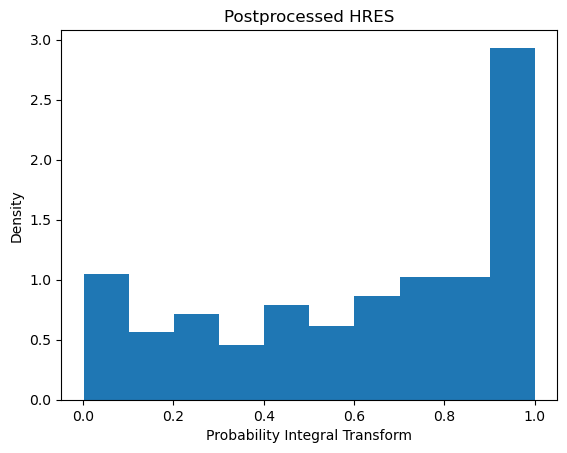

In [37]:
pit = r_pred.pit(y = test_parameters[:,0])
a, b, x = plt.hist(pit, density = True)
plt.title("Postprocessed HRES")
plt.xlabel("Probability Integral Transform")
plt.ylabel("Density")
plt.show()

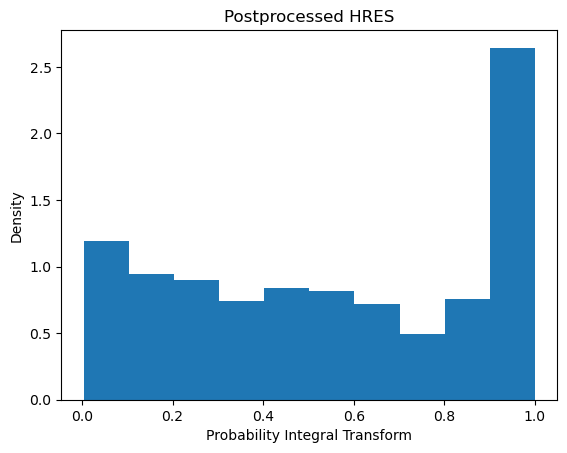

In [38]:
pit = s_pred.pit(y = test_parameters[:,1])
a, b, x = plt.hist(pit, density = True)
plt.title("Postprocessed HRES")
plt.xlabel("Probability Integral Transform")
plt.ylabel("Density")
plt.show()

# Example

In [39]:
i = 319
r_pred = r_fit.predict(pd.DataFrame({"pred" : test_predictions[i:(i+1),0]}, columns = ["pred"]))
s_pred = s_fit.predict(pd.DataFrame({"pred" : test_predictions[i:(i+1),1]}, columns = ["pred"]))

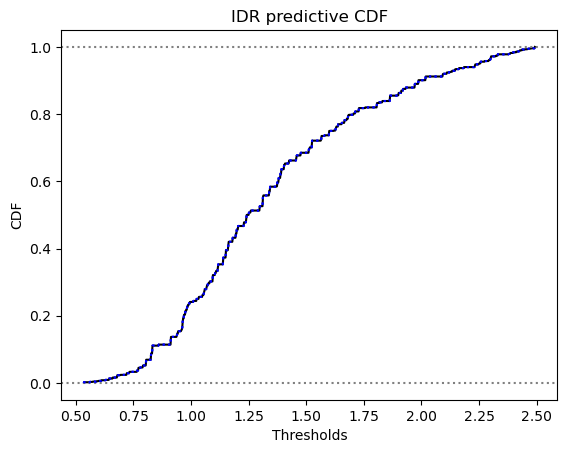

In [40]:
r_pred.plot()

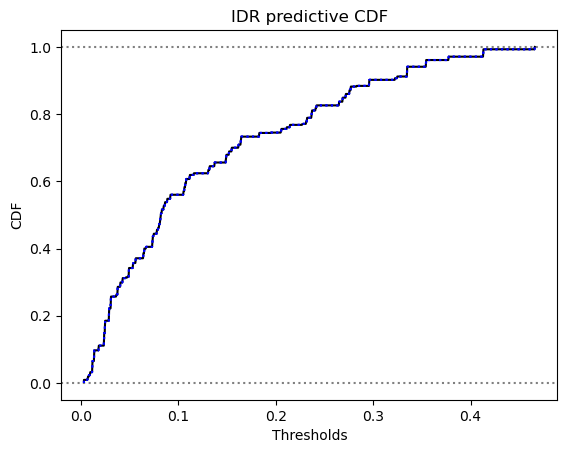

In [41]:
s_pred.plot()

## Plot example

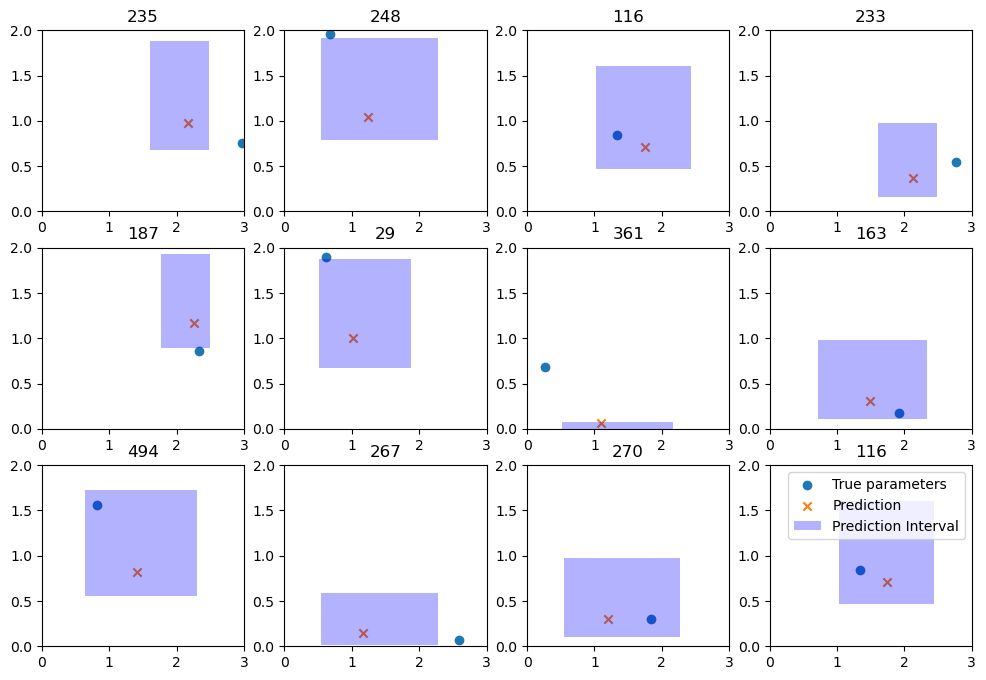

In [42]:
samples = np.random.randint(0,500,12)
fig, axs = plt.subplots(3,4,figsize = (12,8))
axs = axs.ravel()
for x,i in enumerate(samples):
    axs[x].scatter(test_parameters[i,0], test_parameters[i,1], marker = "o", label = "True parameters")
    axs[x].scatter(test_predictions[i,0], test_predictions[i,1], marker = "x", label = "Prediction")
    
    anchor = (r_quantiles[i,0], s_quantiles[i,0])
    rectangle = plt.Rectangle(anchor, (r_quantiles[i,1]-r_quantiles[i,0]), (s_quantiles[i,1]-s_quantiles[i,0]), fc='blue', label = "Prediction Interval", alpha = 0.3)
    axs[x].add_patch(rectangle)
    axs[x].set_xlim(0,3)
    axs[x].set_ylim(0,2)
    axs[x].set_title(f"{i}")
axs[x].legend(["True parameters", "Prediction", "Prediction Interval"])

## Compute scores and coverage

In [43]:
r_coverage = np.sum((test_parameters[:,0] >= r_quantiles[:,0]) & ((test_parameters[:,0] <= r_quantiles[:,1])))/test_samples*100
s_coverage = np.sum((test_parameters[:,1] >= s_quantiles[:,0]) & ((test_parameters[:,1] <= s_quantiles[:,1])))/test_samples*100

In [44]:
r_is, _, _ = interval_score(test_parameters[:,0], 0.05, r_quantiles[:,0], r_quantiles[:,1])
r_is = np.mean(r_is)
s_is, _, _ = interval_score(test_parameters[:,1], 0.05, s_quantiles[:,0], s_quantiles[:,1])
s_is = np.mean(s_is)

In [45]:
print(f"Model: {model}\nCoverage {r_coverage:.2f}%, {s_coverage:.2f}% \nIS: {r_is:.4f}, {s_is:.4f}")

Model: whitmat
Coverage 60.00%, 75.60% 
IS: 5.8743, 5.3252
